In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

Macro `_latex_std_` created. To execute, type its name (without quotes).
=== Macro contents: ===
get_ipython().run_line_magic('run', 'Latex_macros.ipynb')
 

$$
\newcommand{\kernel}{\mathbf{k}}
$$

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
from IPython.display import Image

import cnn_helper
%aimport cnn_helper
cnnh = cnn_helper.CNN_Helper()

# Convolutional Neural Networks (CNN): HIgh Level

<div class="alert alert-block alert-warning">
    <b>TL;DR</b> 
    <br>
    <ul>
        <li> A single unit in Fully Connected (FC) Layer identifies the presence/absence of a single feature spanning the <b>entire</b> input</li>
        <li>A single "kernel" in a Convolutional Layer identifies the presence/absence of a single feature</li>
        <ul>
            <li>Whose size is a fraction of the entire input</li>
            <li>At <b>each</b> sub-span of the input</li>
        </ul>
        
</div>



**Example**
- FC: is the input image the digit "8"
- CNN: are there one or more small "8"'s in the input image

# Convolutional Neural Networks: Introduction

We have seen how the Fully Connected (FC) layer performs a template-matching on the layer's inputs.
$$
\y_\llp = a_\llp ( \W_\llp \y_{(\ll-1)} + b )
$$

- Each element of $\y_{(\ll-1)}$ is independent
    - there is no relationship between $\y_{(\ll-1), j}$ and $\y_{(\ll-1), j+1}$
    - even though they are adjacent in the vector ordering

To see the lack of relationship:

Let $\text{perm}$ be a random ordering of the integers in the range $[1 \ldots n]$.

Then
- $\x[ \text{perm} ]$ is a permutation of input $\x$
- $\Theta[ \text{perm} ]$ is the corresponding permutation of parametrs $\Theta$.

$$
\Theta^T \cdot \x = \x[ \text{perm} ] \cdot \Theta[ \text{perm} ]
$$


So a FC layer cannot take advantage of any explicit ordering among the input elements
- timeseries of prices
- adjacent pixels in an image

Another issue with an FC layer:
- The "template" $\W_\llp$ matches the full length of the input $\y_{(\ll-1)}$ 

There are cases where we might want to discover a feature
- whose length is less than $n$
- that occurs *anywhere* in the input, rather than at a fixed location

For example
- a spike in a timeseries
- the presence of an "eye" in an image

Both these questions motivate the notion of convolutional matching
- small templates
- that are slid over the entire input

By sliding the pattern over the entire input
- we can detect the existence of the feature somewhere in the input
- we can localize its location

<table>
    <tr>
        <th><center>CNN convolution</center></th>
    </tr>
    <tr>
        <td><img src="images/CNN_convolution_1.jpg" width=900></td>
    </tr>
</table>


- We place $(3 \times 3)$ Kernel (weight matrix) on the inputs ($\y_{(0)}$, output of layer 0)
- Performs dot product
- Produces Layer 1 output ($\y_{(1)}$) feature labelled $1$

Slide the Kernel up and repeat:

<table>
    <tr>
        <th><center>CNN convolution</center></th>
    </tr>
    <tr>
        <td><img src="images/CNN_convolution_2.jpg" width=900></td>
    </tr>
</table>

- The dot product *using the identical kernel weights* produces output ($\y_{(1)}$) feature labelled $2$

Repeat, centering the Kernel over each feature in $\y_{(0)}$:

<table>
    <tr>
        <th><center>CNN convolution</center></th>
    </tr>
    <tr>
        <td><img src="images/CNN_convolution_3.jpg" width=900></td>
    </tr>
</table>

The output of a convolution is of similar size as the input
- detects a specific feature *at each input location*

So, for example, if there are
- three spikes: will detect the "is a spike" feature in 3 locations
- two eyes: will detect the "is an eye" feature in two locations

The convolution operation is like
- creating a small (size of template) FC layer
- that is applied to each location

So it "fully connects" *neighboring inputs* rather than the *entire input* and thus takes advantage
of ordering present in the input.

- The template is called a *kernel* or *filter*
- The output of a convolution is called a *feature map*

Pre-Deep Learning: manually specified filters have a rich history for image recognition.

Let's see some in action to get a better intuition.
    

<table>
<center>Fully Connected vs Convolution</center>
<tr>
<img src="images/CNN_vs_FC.jpg" width=600">
</tr>
</table>

- Fully Connected Layer
    - each of the $n_{(l-1)}$ units of layer $(l-1)$ connected to each of the $n_\llp$ units of layer $\llp$
    - $n_{(l-1)} * n_\llp$ weights total
- Convolutional Layer with 1D convolution, filter size 3
    - groups of $3$ units of layer $(l-1)$ connected to *individual* units of layer $\llp$
    - using the *same* 3 weights
    - 3 weights total

So a Convolutional Layer can use *many fewer* weights/parameters than a Fully Connected Layer.

As we will see, this enables us to create *many* separate convolutions in a single layer

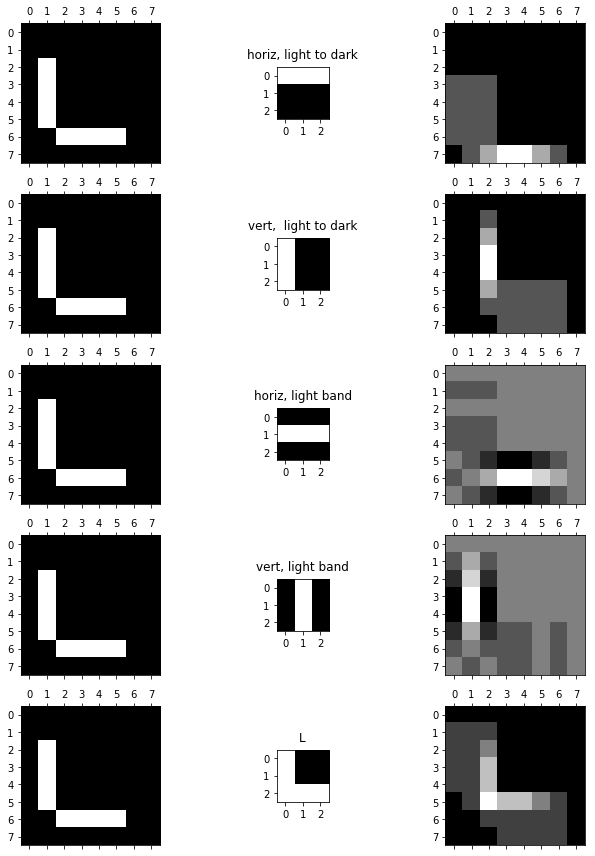

In [4]:
_= cnnh.plot_convs()

- A bright element in the output indicates a high, positive dot product
- A dark element in the output indicates a low (or highly negative) dot product

In our example, the kernel is $(3 \times 3)$.

The template match will be maximized when
- high values in the input correspond to high values in the matching location of the template
- low values in the input correspond to low values in the matching locations of the template

Here is a list of manually constructed kernels (templates) that have proven useful
- [list of filter matrices](https://en.wikipedia.org/wiki/Kernel_(image_processing))

- How do we construct a "good" kernel ?
- How do we decide which one to use ?

It all depends on the objective.

Machine Learning to the rescue: let an ML algorithm "learn" the kernel that is best suited to the task.


For example, consider a two layer Sequential model
- First layer is a convolution with kernel $\kernel$
- Second layer if a classifier with parameters $\Theta$

Let $\loss$ be some loss function appropriate to classifcation, e.g, cross entropy.

Then our ML Swiss Army Knife (Gradient Descent) solves for the loss-minimizing values of $\Theta, \kernel$
$$
\Theta, \kernel = \argmin{\Theta, \kernel} \loss
$$



## CNN advantages/disadvantages

**Advantages**
- Translational invariance
    - feature can be anywhere
- Locality
    - feature depends on nearby features, not the entire set of features
    - reduced number of parameters compared to a Fully Connected layer
    


**Disadvantages**
- Output feature map is roughly same size as input
    - lots of computation to compute a single output feature
        - one per feature of input map
    - higher computation cost
        - training and inference
- Translational invariance not always a positive

## Multiple kernels

We have thus far seen a *single* kernel, applied to a $N=2$ dimensional input $\y_{(\ll-1)}$.

The output $\y_\llp$ is an $N$ dimensional feature map that identifies the presence/absence
of a feature at each element of $\y_{(\ll-1)}$.

Why not use *multiple* kernels to identify *multiple* features ?
- Let Convolutional Layer $\ll$ have $n_{\llp,1}$ kernels
- The output is $n_{\llp,1}$ feature maps, one per kernel, identifying the presence/absence of one feature each

This is similar in concept to a Fully Connected layer
- Let FC layer $\ll$ have $n_\llp$ units/neurons
- The output is a vector of $n_\llp$ features

Let $(n_{(\ll-1),1} \times n_{(\ll-1),2})$ denote the shape of $\y_{(\ll-1)}$.

If Convolutional Layer $\ll$ has $n_{\llp,1}$ kernels
- the output shape is $(n_{\llp,1} \times n_{(\ll-1),1} \times n_{(\ll-1),2})$

That is, the input is replicated $n_\llp$ times, one per kernel of layer $\ll$.

<table>
       <center>CNN convolution</center>
    <tr>
        <td><img src="images/CNN_feature_map.jpg" width=600></td>
    </tr>
</table>


It also means that the matrix $\kernel_\llp$ representing the kernels at layer $\ll$
has the same number of dimensions as the output
- the first dimension is the number of kernels
- the rest of the dimensions are the size of each kernel

## Higher dimensional input ($N > 2$)

After applying $n_{\llp,1}$ kernels to $N=2$ dimensional input $\y_{(\ll-1)}$
of shape
$(n_{(\ll-1),1} \times n_{(\ll-1),2})$ 
we get a three dimensional output of shape $(n_{\llp,1} \times n_{(\ll-1),1} \times n_{(\ll-1),2})$.

What happens when input $\y_{(\ll-1)}$ is $N=3$ dimensional 
of shape
$(n_{(\ll-1),1} \times n_{(\ll-1),2} \times _{(\ll-1),3})$ ?

- this can easily occur in layer $(\ll-1)$ is a Convolutional Layer with $n_{(\ll-1),1}$ kernels

If $\y_{(\ll-1)}$ is the output of a Convolutional Layer
- $\y_{(\ll-1)}$ has $n_{(\ll-1),1}$ features over a space of shape $(n_{(\ll-1),2} \times _{(\ll-1),3})$

Convolutional Layer $\ll$ 
- combines  all $n_{(\ll-1),1}$ input features at a single "location" 
- into a new synthetic *scalar* feature at the same location in output $\y_\llp$

This means the output $\y_\llp$ is of shape $(n_{\llp,1} \times n_{(\ll-1),2} \times _{(\ll-1),3})$



This implies that *each kernel* of layer $\ll$ is of dimension $N_{(\ll-1)}$

For example: if layer $(\ll -1)$ has $N_{(\ll -1)} = 3$ dimensions
- each kernel of layer $\ll$ is has 3 dimensions

## Kernel shape

We see that a Convolutional Layer $\ll$ transforms
- an input of dimension $(n_{(\ll-1),1} \times n_{(\ll-1),2} \times n_{(\ll-1),3})$
- into output with dimension $(n_{\llp,1} \times n_{(\ll-1),2} \times n_{(\ll-1),3})$

If each kernel of layer $\ll$ has shape $(k_1 \times k_2)$ then the kernel matrix $\kernel_\llp$ for layer $\ll$
- has shape $(n_{\llp,1} \times k_1 \times k_2)$
- one kernel per output synthetic feature

# Simple case: 1d convolution

We have thus far illustrated Convolution with input layer $0$ having $\x^\ip$ of dimension $N_{(0)} \in \{2,3 \}$.

We can generalize the logic to tensors of dimension $N > 3$.

But we also have the simplest case of $N=1$.
- can consider the one dimensional $\x^\ip$ has being two dimensional with leading dimension $1$

One dimensional convolution is quite common
- timeseries of prices
- sequence of words



Consider a time series of prices of length 5
- a positive spike at elements 1 and 3
- a FC has no order
    - can't distinguish between $[+,-+]$ and $[+,+,-]$
    - but a 1D convolution with kernel size 3 can

Consider a sequence of words
- an FC cannot distinguish $["not", "like", "ML"]$ from $["ML", "not", "like"]$
    - but a 1D convolution with kernel size 3 can

So Convolutional Layers can impose a partial ordering (within range of kernel) where FC Layers cannot.

This doesn't completely address the issue of inputs that are sequences as the "field"
of ordering is only within (a small) kernel.

We will learn to deal with sequences when we study Recurrent Neural Networks.


# Technical points

## Convolution versus Cross Correlation
- math definition of convolution
    - dot product of input and *reversed* filter
    - we are doing [cross correlation](https://en.wikipedia.org/wiki/Convolution_

## Extending the dot product to higher dimensions

The "dot product" notation $\kernel \cdot \y_{(\ll-1)}$
is extended over higher dimensions
- that is: flatten both $\kernel$ and $\y_{(\ll-1)}$ and apply the one dimensional dot product

# Terminology

- a *kernel* or *filter* is a pattern
    - slide over each element of the input
- a *feature map* or *activation map* is the output of applying a single kernel to the input
    - similar shape to the input (will discuss padding)
    - identifies the presence/absence of a feature *at each* location of the input space

# Border control: Padding

We have glossed over an important fact:
- What happens when the kernel center is located at an edge ?
    - That is: part of the kernel lies outside of the input
    

Up until now
- we have been treating the size of feature map of layer $(\ll -1)$ and layer $\ll$
as being the same size.

In order for that to be true
- we need to "pad" the borders of the input, usually with 0 values
    
There are several variants of padding.

- same, full
    - Output feature map the same size as input feature map
- valid
    - **No** padding
    - Output feature map small than input feature map (by half of the kernel size)
- causal
    - For input that has a temporal ordering: don't peek into the future !
        - 1D convolutions
        - pad "earlier" time with 0; no padding for "later"
       



# Receptive field

The *receptive field* of a elements of a feature map
- are the Layer 0 (input) features that affect features in the map.


For ease of notation:
- we assume $N=2$ as the dimension of the kernel
- we assume that all $N$ dimensions of the kernel are the same ($f_\llp$)

So we will assume without loss of generality that
- the "height" and "width" of a single kernel kernel is $(f \times f)$
- the full dimensionality of a single layer $\ll$ kernel is $(n_{(\ll-1),1} \times f \times f)$



Thus the receptive field of a Convolutional Layer at layer $1$ is $(f \times f)$.

## Increasing the Receptive Field

There are several ways to "widen" the receptive field
- Increasing $f_\llp$, the size of the kernel
- Stacking Convolutional Layers
- Stride
- Pooling

Striding and Pooling also have the effect of reducing the size of the output feature map.

## Increase the size of the kernel

Although this is the most *obvious* way of increasing the receptive field, we tend to avoid it !

We will see the reason shortly.

## Stacking Convolutional Layers

As you go one layer deeper in the NN, the receptive field width and height increase by (2 * *stride*)

<table>
    <tr>
        <th><center>CNN receptive field</center></th>
    </tr>
    <tr>
        <td><img src="images/CNN_Receptive_field.jpg" width=600></td>
    </tr>
</table>


- Each grid in Layer 1 refers to the *same* features in Layer 0
- The layer 2 feature labelled $i$ is a function of the Layer 1 features labelled $i$
- By completing the $(3 \times 3)$ grid in Layer 2:
    - all $(5 \times 5)$ layer 0 features are touched

|  Layer  | Receptive field |
|-- |-- |
1 | $(3 \times 3)$
1 | $(5 \times 5)$
1 | $(7 \times 7)$

## Strides

Thus far, we have slid the kernel over *each* feature of the input feature map.

That is: the kernel moves with *stride* $S = 1$

Alternatively, we could skip $(S-1)$ features of the input feature map with stride $S > 1$.

This will 
- enlarge the receptive field
- decrease the size of the output feature map

## Pooling

We can "down sample" a feature map by combining features.

For example: we can replace a $(2 \times 2)$ region of feature values with a single average value.

This is called *pooling*.

When combined with a stride $S > 1$ this results in "down sampling" (reduced spatial dimensions).

After pooling, each synthetic feature is a function of more than one features of the prior layer.

Pooling will
- enlarge the receptive field
- decrease the size (assuming $S > 1$) of the pooling layer's output feature map


### Pooling operations
- Average pooling
    - average over the kernel 
- Max pooling
    - Max over the kernel
    
Pooling without a kernel:
- Global average pooling
    - replace each feature map with a single value: the maximum over the spatial dimensions
- K-Max pooling
    - replace one dimension of the volume with the $K$ largest elements of the dimension


# Size of output

We can relate the size of a layer's output feature map to the size of its input feature map:

- input $W_i \times H_i \times D_i$
- $N$: input size $N \times N$
- $F$: filter size $F \times F$
- $S$: stride
- $P$: padding

No padding
- output size $( (W_i -F)/S +1 ) \times ( (H_i - F)/S +1 ) \times D_o$

Padding
- output size $( (W_i -F +2P)/S +1 ) \times ( (H_i - F +2P)/S +1 ) \times D_o$

    
Assuming full padding, a layer $\ll$ Convolutional Layer with $n_{\llp,1}$ kernels will have output $\y_\llp$ dimension
- $(n_{\llp,1} \times n_{(\ll-1),2} \times n_{(\ll-1),3})$
    - $n_{\llp,1}$ features
    - over a spatial map of $(n_{(\ll-1),2} \times n_{(\ll-1),3})$
    
That is, the number of features changes but the spatial dimension is similar to $\y_{(\ll-1)}$

## Down-sampling: Why does output size matter

Convolution applies a kernel to *each* region of the input feature map (assuming $S=1$).

Reducing the size of feature map at layer $(\ll-1)$ 
- will reduce the number of operations
performed by Convolution at layer $\ll$.

For image inputs (with thousands or millions of input features) there is a incentive to down-sample
- Speed up training
- Speed up inference


Down-sample by
- Increasing Stride
- Pooling

# Number of parameters

The real power of convolution comes from using the *same* filter against all locations of the input.

As a result, the number of parameters is quite small (compared to a separate set of parameters per each input).

- Dimension of a single filter $F \times F \times D_i$
- $D_o$: number of output filters
- total parameters: $F * F * D_i * D_o$

Remember: there is a depth to the input and the filter applies to the entire input depth
- size of a filter $F *F * D_i$
- number of filters: $D_o$, one per output channel
- total: $F * F * D_i * D_o$

If we were to have a separate filter for each input location, the number of parameters would increase
by a factor of $W_i * H_i$.

# Why Stacking Conv Layers beats larger kernels

A single Conv layer kernel with $f=5$ 
- Has the same receptive field $(5 \times 5)$
- As two stacked layers with kernel size $f=3$.

Why might we prefer the latter ?

Let's consider a Convolutional Layer $\ll$.
- The number of features at the input feature map is $n_{(\ll-1),1}$
- The number of features at the output feature map is $n_{\llp,1}$
- The number of weights in each kernel of layer $\ll$ is $(n_{(\ll-1),1}\times f_\llp)$ (assuming $N=2$)


- The single Convolutional Layer $\ll$ with  kernel size $f_\llp = f$ uses
    - $n_{\llp,1} * (n_{(\ll-1),1} * f^2)$ weights
- Two stacked Convolutional Layers $\ll, (\ll+1)$, each with kernel size $f_\llp = f_{(\ll +1)} = g$ uses
    - $2 * n_{\llp,1} * (n_{(\ll-1),1} * g^2)$ weights

The single Convolutional Layer uses $\frac{f^2}{2 g}$ times as many weights.

For $f = 5, g=3$: single layer uses almost 3 times (25/9) as many weights !

For $f = 7, g=3$: single layer uses almost 5+ times (49/9) as many weights !

So it is more parameter efficient to use multiple layers to increase receptive field.

Increased depth has another advantage:
- each additional layer introduces another non-linear activation

Increase non-linearity may result in more complex features being learned.

Early CNN's tended to use larger kernels.

Today, $(3 \times 3)$ kernels, with many layers, is more common.


# Kernel size 1

Why might one want $f_\llp =1$
- i.e, a $(1 \times 1)$ kernel ?

Remember that Convolutional Layer $\ll$ transforms
- an input of dimension $(n_{(\ll-1),1} \times n_{(\ll-1),2} \times n_{(\ll-1),3})$
- into output with dimension $(n_{\llp,1} \times n_{(\ll-1),2} \times n_{(\ll-1),3})$

by combining the $(n_{(\ll-1),1} \times f_\llp \times f_\llp)$ features of layer ($\ll -1)$ at a time.

Setting $f_\llp = 1$ combines the $n_{(\ll-1),1}$ layer $(\ll-1)$ features at *each* location into a single
layer $\ll feature.

So $f_\llp = 1$ is a simple way of reducing the number of features from $n_{(\ll-1),1}$ to $n_{\llp,1}$
- Using only $(1 * n_{\llp,1})$ weights !

# CNN Math: Time versus number of parameters

For simplicity, we will assume that the layers of our NN have
data in 3 dimensions:
- the first dimension indexes a feature map (i.e., layer encodes a feature at each spatial location)
- the final two dimensions are the spatial dimensions (i.e, height and width)

Consider a convolutional layer $\ll$, that uses full padding
- operating on input $\y_{(\ll-1)}$ of dimension $(n_{(\ll-1),1} \times n_{(\ll-1),2} \times n_{(\ll-1),3})$
    - $n_{(\ll-1),1}$ feature maps over spatial locations of dimension $(n_{(\ll-1),2} \times n_{(\ll-1),3})$
- using $n_{\llp,1}$ kernels of shape $(f_\llp \times f_\llp)$ to produce $n_{\llp,1}$   output feature maps
    - spatial dimensions $(n_{\llp,2} \times n_{\llp,3}) = (n_{(\ll-1),2} \times n_{(\ll-1),3})$

Let's measure the space (number of parameters) and time (number of operations) of layer $\ll$:
- Number of parameters (shape of kernel $\kernel_\llp$)
    - $n_{\llp,1} \times n_{(\ll-1),1} \times f_\llp \times f_\llp$
- Number of multiplications to produce $\y_\llp$ via the Convolutiona Layer
    - $n_{\llp,1} \times n_{(\ll-1),1} \times f_\llp \times f_\llp \times n_{(\ll-1),2} \times n_{(\ll-1),3}$

A Convolutional Layer's space requirements
- Number of parameters relatively efficient
    - contingent on the number of feature maps of the input and output
    - not their spatial dimension
- Size of output
    - contingent on number of feature maps of the input and output
    - **and** their spatial dimension

The number of operations (element-wise multiplications) can be quite large
- contingent on number of feature maps of the input and output **and** their spatial dimension
- will impact speed of both training and inference (test time)

It becomes of great practical importance to control the space and time requirements.

This becomes most apparant when connecting the final Convolutional Layer $\ll -1$ to
a Fully Connected layer $\ll$
- usually happens in the head of a NN, prior to classification or regression
- Suppose FC layer $\ll$ has $n_\ll$ units (and we flatten the volume of $\y_{(\ll-1)}$ to one dimension)
- number of parameters for the FC layer:
    - $n_\llp \times n_{(\ll-1),1} \times n_{(\ll-1),2} \times n_{(\ll-1),3}$
    - $n_\llp$ typically large so as to not lose too much information relative to $\y_{(\ll-1)}$

Let's summarize our knowledge of controlling the size of $\y_{(\ll-1)}$:
- Controlling spatial dimensions
    - Increase stride
    - Pooling
        - Global average pooling often used in final Convolutional Layer
- Control number of feature maps per layer
    - Choice of $n_{\llp,1}$
    - Kernel size $f_\llp = 1$
        - preserve spatial dimension
        - change number of feature maps from $n_{(\ll-1),1}$ to $n_{\llp,1}$
 

Striding and Pooling
- increase receptive field
- typically small values (e.g., $S=2$) 
    - limited reduction

Kernel size $f_\llp = 1$
- reduction depends on the ratio of $n_{\llp,1}$ to $n_{(\ll-1),1}$
    - unlimited reduction possible

# Convolution as matrix multiplication
[A guide to convolutional arithmetic for deep learning](https://arxiv.org/pdf/1603.07285.pdf)

Convolution involves a multi-dimensional dot product over a large volume
- each location, of each input feature map

Doing this in a loop would be very expensive.

There are many highly efficient libraries for matrix multiplication
- some of which can take advantage of parallelism and GPU's.

Geron equation 13-1



We can turn convolution into matrix multiplication.

For simplicity, we will show this for a single channel, using a $(3 \times 3)$ kernel on a $(4 \times 4 \times 1)$ input volume.

Basically: we flatten out both the kernel matrix $W$ 

$$
W = \begin{pmatrix}
w_{0,0} & w_{0,1} & w_{0,2} \\
w_{1,0} & w_{1,1} & w_{1,2} \\
w_{2,0} & w_{2,1} & w_{2,2}
\end{pmatrix}
$$
and the input volume matrix.

Since the input volume is $(16 \times 1)$, we will left multiply by a matrix with number of rows equal to the output volume, and $16$ columns.

For simplicity, we do this without padding, so the output volume is $(2 \times 2)$ which flattened is $(4 \times 1)$

$C = \begin{pmatrix}
    w_{0,0} & w_{0,1} & w_{0,2} & 0 & w_{1,0} & w_{1,1} & w_{1,2} & 0 & w_{2,0} & w_{2,1} & w_{2,2} & 0 & 0 & 0 & 0 & 0 \\
    0       & w_{0,0} & w_{0,1} & w_{0,2} & 0 & w_{1,0} & w_{1,1} & w_{1,2} & 0 & w_{2,0} & w_{2,1} & w_{2,2} & 0 & 0 & 0 & 0 \\
    0       & 0       & 0       & 0       & w_{0,0} & w_{0,1} & w_{0,2} & 0 & w_{1,0} & w_{1,1} & w_{1,2} & 0 & w_{2,0} & w_{2,1} & w_{2,2} & 0 \\
    0 & 0       & 0       & 0       & 0       & w_{0,0} & w_{0,1} & w_{0,2} & 0 & w_{1,0} & w_{1,1} & w_{1,2} & 0 & w_{2,0} & w_{2,1} & w_{2,2} 
  \end{pmatrix}
  $

Once you understand that the convolution result
- is obtained as $C X'_{l}$ 
- (where $X'_{l}$ is the flattened inputs to layer $l$), 
- you can imagine an inverse of $C$ to go from the convolution result
backwards to $X'_{l}$.

That is, we can trace backwards from each activation in a feature map to the inputs that went into its
computation.

This will enable us to do back propagation.


## Inverting convolution

For a variety of reasons, it will prove useful to invert the convolution operation.

For example
- if we view convolution as down-sampling, there will be cases where we want to restore the original volume by up-sampling
- we want to know which elements of the input volume contribute to a particular element of the output volume
    - need to back propagate the gradient
- we may want to know which elements of the input volume contribute most to an element of the output volume (perhaps an output volume several layers removed)


We will discuss these in the context of understanding what a layer of a CNN is "looking for".

# How many filters to use (what is the correct  number of channels ?)
 [Bag of Tricks for Image Classification with CNNs](https://arxiv.org/abs/1812.01187)
 
Suppose the kernel size for a CNN layer is $(W \times H \times D)$ (thus operating on an input whose channel depth is $D$).

Then each convolution dot product is a function of $N = (W*H*D)$ inputs.

Having more than $N$ output channels is the opposite of compressing the input: we are generating more
values than in the input.

So we can argue for $N$ as an  upper bound.

This argument is mitigated somewhat by the "lottery ticket" argument: 
- having extra neurons, even if many are eventually "dead" (unused, and hence can be pruned), facilitates training
 

In [5]:
print("Done")

Done
